In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import torch
from xgboost import XGBRegressor, plot_importance

In [4]:
# Load CSV file
file_path = "/Users/saipavanrevooru/WorkSpace/Projects/SCPP/StaticCodePowerPredictor/output/power_dataset_last.csv"  # Update with your file path
df = pd.read_csv(file_path)

In [6]:
df["power_mw"] = df["power_mw"].round().astype(int)

In [8]:
df.head()

,num_functions,cyclomatic_complexity,num_loops,num_function_calls,num_memory_allocations,num_pointer_operations,num_exp_math_operations,instruction_count,arithmetic_instr_pct,memory_instr_pct,control_instr_pct,control_path_depth,power_mw
0,10485,5096,3251,8136,1754,9,2652,168837,1.57,1.04,3.02,2,2466
1,8723,3772,2807,5799,1130,9,1376,133641,1.03,0.85,2.82,2,2435
2,9198,3271,2422,6114,48,9,1256,130839,0.96,0.04,2.50,2,2436
3,10381,4960,3760,7992,732,9,2724,177410,1.54,0.41,2.80,2,2329
4,9032,3124,2550,4762,8,9,26,130562,0.02,0.01,2.39,2,2359


In [10]:
# Display basic info
print("Original DataFrame:")
print(df.info())
print(df.describe())

Original DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8924 entries, 0 to 8923
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_functions            8924 non-null   int64  
 1   cyclomatic_complexity    8924 non-null   int64  
 2   num_loops                8924 non-null   int64  
 3   num_function_calls       8924 non-null   int64  
 4   num_memory_allocations   8924 non-null   int64  
 5   num_pointer_operations   8924 non-null   int64  
 6   num_exp_math_operations  8924 non-null   int64  
 7   instruction_count        8924 non-null   int64  
 8   arithmetic_instr_pct     8924 non-null   float64
 9   memory_instr_pct         8924 non-null   float64
 10  control_instr_pct        8924 non-null   float64
 11  control_path_depth       8924 non-null   int64  
 12  power_mw                 8924 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 906.5 KB
None
     

In [12]:
# 1. Remove duplicate rows
df = df.drop_duplicates()

# 2. Handle missing values
df = df.dropna()  # Drop rows with missing values (alternative: fill with mean/median)

In [14]:
# 3. Ensure correct data types
for col in df.select_dtypes(include=['object']).columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='ignore')  # Convert numerical strings to numbers
    except:
        pass

/var/folders/0w/d6mg_1rx63jcpkq1mfpclt980000gn/T/ipykernel_1014/1328651030.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


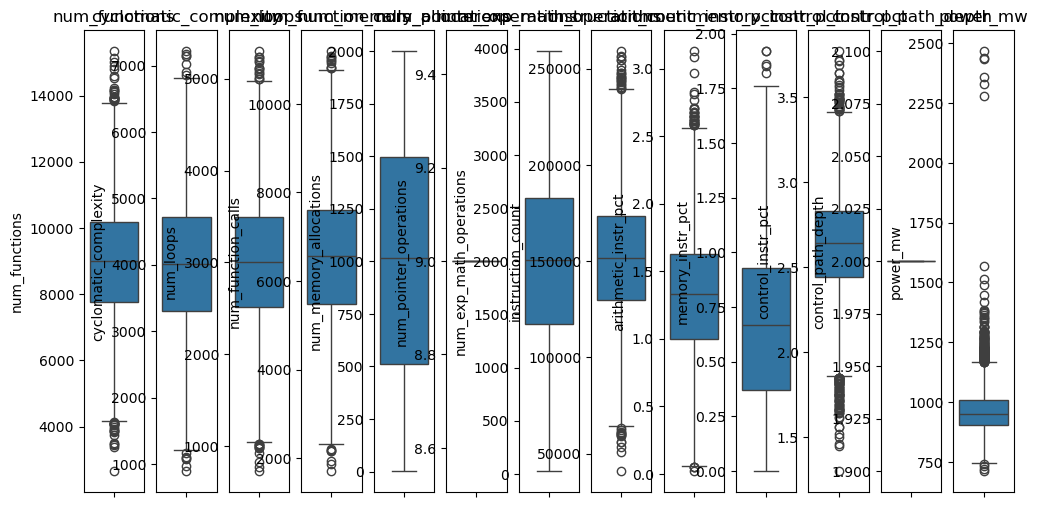

In [16]:
# 4. Visualize outliers before removal
numeric_cols = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [18]:
# Aggressive IQR filtering
df_cleaned = df.copy()
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1 * IQR  # More aggressive (default is 1.5)
    upper_bound = Q3 + 1 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

In [20]:
# scaler = RobustScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

In [22]:
# joblib.dump(scaler, "scaler.pkl")

In [24]:
# df_scaled = df_scaled.drop(columns=["num_pointer_operations"])

/var/folders/0w/d6mg_1rx63jcpkq1mfpclt980000gn/T/ipykernel_1014/232143039.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


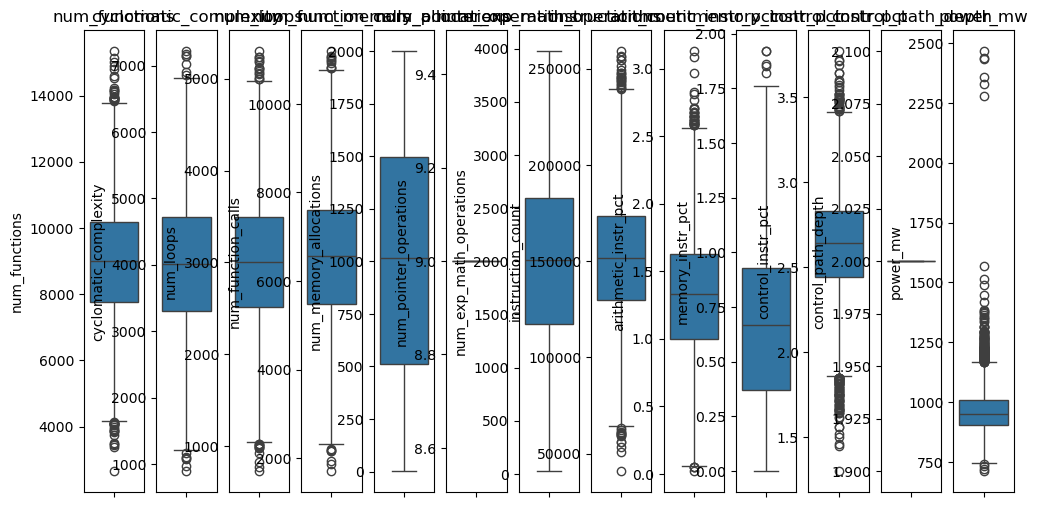

In [26]:
# 4. Visualize outliers after removal
numeric_cols = df_cleaned.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [28]:
# Display basic info
print("Cleaned DataFrame:")
print(df_cleaned.info())
print(df_cleaned.describe())

Cleaned DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 7097 entries, 13 to 8923
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_functions            7097 non-null   int64  
 1   cyclomatic_complexity    7097 non-null   int64  
 2   num_loops                7097 non-null   int64  
 3   num_function_calls       7097 non-null   int64  
 4   num_memory_allocations   7097 non-null   int64  
 5   num_pointer_operations   7097 non-null   int64  
 6   num_exp_math_operations  7097 non-null   int64  
 7   instruction_count        7097 non-null   int64  
 8   arithmetic_instr_pct     7097 non-null   float64
 9   memory_instr_pct         7097 non-null   float64
 10  control_instr_pct        7097 non-null   float64
 11  control_path_depth       7097 non-null   int64  
 12  power_mw                 7097 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 776.2 KB
None
       num

In [30]:
df_cleaned.corr()

,num_functions,cyclomatic_complexity,num_loops,num_function_calls,num_memory_allocations,num_pointer_operations,num_exp_math_operations,instruction_count,arithmetic_instr_pct,memory_instr_pct,control_instr_pct,control_path_depth,power_mw
num_functions,1.000000,0.721735,0.757964,0.869615,0.302551,NaN,0.422853,0.895197,0.002620,0.025645,-0.042513,NaN,0.017838
cyclomatic_complexity,0.721735,1.000000,0.924323,0.734484,0.534931,NaN,0.566675,0.895055,0.170363,0.269157,0.564998,NaN,-0.008890
num_loops,0.757964,0.924323,1.000000,0.735378,0.339184,NaN,0.536111,0.935704,0.113963,0.045558,0.326141,NaN,-0.001517
num_function_calls,0.869615,0.734484,0.735378,1.000000,0.551779,NaN,0.807739,0.853477,0.483013,0.303736,0.057527,NaN,0.010815
num_memory_allocations,0.302551,0.534931,0.339184,0.551779,1.000000,NaN,0.660856,0.412802,0.550235,0.936957,0.416232,NaN,0.002228
num_pointer_operations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_exp_math_operations,0.422853,0.566675,0.536111,0.807739,0.660856,NaN,1.000000,0.566056,0.871971,0.513165,0.207886,NaN,-0.003535
instruction_count,0.895197,0.895055,0.935704,0.853477,0.412802,NaN,0.566056,1.000000,0.114497,0.106440,0.145634,NaN,0.009624
arithmetic_instr_pct,0.002620,0.170363,0.113963,0.483013,0.550235,NaN,0.871971,0.114497,1.000000,0.559760,0.161817,NaN,-0.008585
memory_instr_pct,0.025645,0.269157,0.045558,0.303736,0.936957,NaN,0.513165,0.106440,0.559760,1.000000,0.399753,NaN,-0.000323


In [32]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import optuna
# from sklearn.model_selection import KFold, train_test_split, GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from catboost import CatBoostRegressor, Pool
# import xgboost as xgb

# X = df_scaled.drop(columns=['power_mw'])
# y = df_scaled['power_mw'].values

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# xgb_mse_list, tabnet_mse_list, ensemble_mse_list, stack_mse_list = [], [], [], []
# xgb_r2_list, tabnet_r2_list, ensemble_r2_list, stack_r2_list = [], [], [], []

# # Optuna XGBoost Tuning
# def xgb_objective(trial):
#     params = {
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         "n_estimators": 100,
#         "objective": "reg:squarederror",
#         "eval_metric": "rmse"
#     }
#     scores = []
#     for train_idx, val_idx in kf.split(X):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]
#         model = xgb.XGBRegressor(**params)
#         model.fit(X_train, y_train)
#         preds = model.predict(X_val)
#         scores.append(mean_squared_error(y_val, preds))
#     return np.mean(scores)

# xgb_study = optuna.create_study(direction="minimize")
# xgb_study.optimize(xgb_objective, n_trials=20)
# best_xgb_params = xgb_study.best_params
# print("Best XGBoost Parameters:", best_xgb_params)

# # Optuna CatBoost Tuning
# def catboost_objective(trial):
#     params = {
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#         'iterations': 100,
#         'loss_function': 'RMSE',
#         'verbose': 0
#     }
#     scores = []
#     for train_idx, val_idx in kf.split(X):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]
#         model = CatBoostRegressor(**params)
#         model.fit(X_train, y_train)
#         preds = model.predict(X_val)
#         scores.append(mean_squared_error(y_val, preds))
#     return np.mean(scores)

# cat_study = optuna.create_study(direction="minimize")
# cat_study.optimize(catboost_objective, n_trials=20)
# best_cat_params = cat_study.best_params
# print("Best CatBoost Parameters:", best_cat_params)

# # Final Evaluation
# for train_idx, val_idx in kf.split(X):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     # XGBoost
#     xgb_model = xgb.XGBRegressor(**best_xgb_params)
#     xgb_model.fit(X_train, y_train)
#     y_pred_xgb = xgb_model.predict(X_val)

#     # CatBoost
#     cat_model = CatBoostRegressor(**best_cat_params, verbose=0)
#     cat_model.fit(X_train, y_train)
#     y_pred_cat = cat_model.predict(X_val)

#     # Weighted Ensemble
#     alpha = 0.7
#     beta = 0.3
#     y_pred_ensemble = (alpha * y_pred_xgb) + (beta * y_pred_cat)

#     # Stacking Ensemble
#     stack_model = StackingRegressor(
#         estimators=[
#             ('xgb', xgb_model),
#             ('cat', cat_model)
#         ],
#         final_estimator=Ridge()
#     )
#     stack_model.fit(X_train, y_train)
#     y_pred_stack = stack_model.predict(X_val)

#     # Metrics
#     xgb_mse_list.append(mean_squared_error(y_val, y_pred_xgb))
#     tabnet_mse_list.append(mean_squared_error(y_val, y_pred_cat))
#     ensemble_mse_list.append(mean_squared_error(y_val, y_pred_ensemble))
#     stack_mse_list.append(mean_squared_error(y_val, y_pred_stack))

#     xgb_r2_list.append(r2_score(y_val, y_pred_xgb))
#     tabnet_r2_list.append(r2_score(y_val, y_pred_cat))
#     ensemble_r2_list.append(r2_score(y_val, y_pred_ensemble))
#     stack_r2_list.append(r2_score(y_val, y_pred_stack))

#     # Plotting
#     plt.figure(figsize=(10, 6))
#     plt.scatter(y_val, y_pred_stack, alpha=0.5, color='blue', label="Stacked Predictions")
#     max_val = max(max(y_val), max(y_pred_stack))
#     plt.plot([0, max_val], [0, max_val], linestyle='--', color='red', label="Ideal Line")
#     plt.xlabel("Actual Power (mW)")
#     plt.ylabel("Predicted Power (mW)")
#     plt.title("Actual vs Stacked Predicted Power Consumption")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Summary
# print(f"XGBoost Avg MSE: {np.mean(xgb_mse_list):.4f} ± {np.std(xgb_mse_list):.4f} | R²: {np.mean(xgb_r2_list):.4f}")
# print(f"CatBoost Avg MSE: {np.mean(tabnet_mse_list):.4f} ± {np.std(tabnet_mse_list):.4f} | R²: {np.mean(tabnet_r2_list):.4f}")
# print(f"Ensemble Avg MSE: {np.mean(ensemble_mse_list):.4f} ± {np.std(ensemble_mse_list):.4f} | R²: {np.mean(ensemble_r2_list):.4f}")
# print(f"Stacked Avg MSE: {np.mean(stack_mse_list):.4f} ± {np.std(stack_mse_list):.4f} | R²: {np.mean(stack_r2_list):.4f}")


In [34]:
# Display basic info
print("Cleaned DataFrame:")
print(df_cleaned.info())
print(df_cleaned.describe())

Cleaned DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 7097 entries, 13 to 8923
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_functions            7097 non-null   int64  
 1   cyclomatic_complexity    7097 non-null   int64  
 2   num_loops                7097 non-null   int64  
 3   num_function_calls       7097 non-null   int64  
 4   num_memory_allocations   7097 non-null   int64  
 5   num_pointer_operations   7097 non-null   int64  
 6   num_exp_math_operations  7097 non-null   int64  
 7   instruction_count        7097 non-null   int64  
 8   arithmetic_instr_pct     7097 non-null   float64
 9   memory_instr_pct         7097 non-null   float64
 10  control_instr_pct        7097 non-null   float64
 11  control_path_depth       7097 non-null   int64  
 12  power_mw                 7097 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 776.2 KB
None
       num

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8}


/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


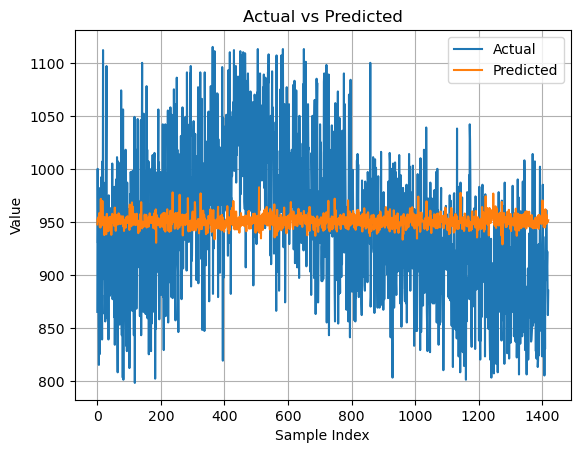

/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


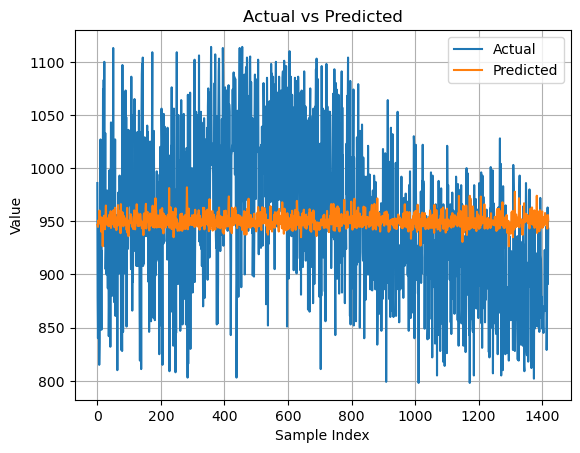

/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


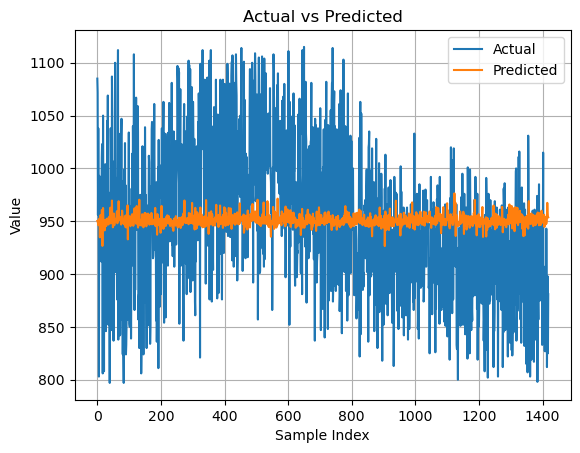

/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


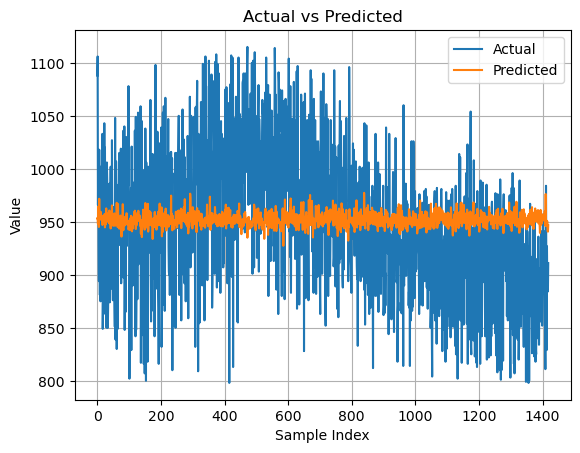

/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


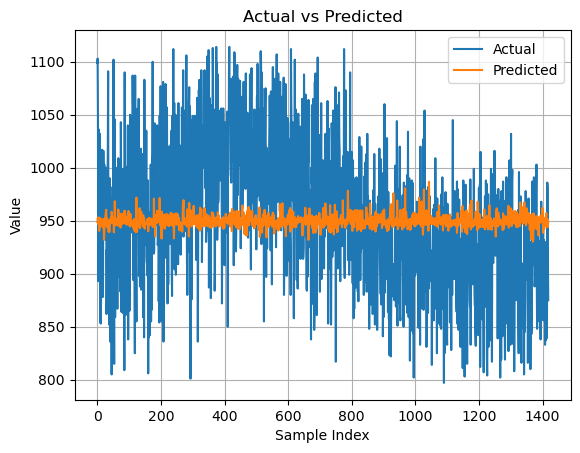

XGBoost Avg MSE: 4749.6532 ± 153.2116
TabNet Avg MSE: 4693.3850 ± 138.7138
Ensemble Model Avg MSE: 4720.6692 ± 148.3472


In [36]:
# Feature-target split
X_raw = df_cleaned.iloc[:, :-1].values
y_raw = df_cleaned.iloc[:, -1].values.reshape(-1, 1)

# Scale features and target
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X = X_scaler.fit_transform(X_raw)
y = y_scaler.fit_transform(y_raw).flatten()

# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_mse_list, tabnet_mse_list, ensemble_mse_list = [], [], []

# XGBoost Grid Search
xgb_param_grid = {
    "learning_rate": [0.1, 0.5, 0.05],
    "max_depth": [4, 5, 6],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

xgb_grid = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse"),
    param_grid=xgb_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1
)
xgb_grid.fit(X, y)
best_xgb_params = xgb_grid.best_params_
print("Best XGBoost Parameters:", best_xgb_params)

all_actual_values = []
all_predicted_values = []
# Cross-validation
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    xgb_model = xgb.train(best_xgb_params, dtrain, num_boost_round=100)
    y_pred_xgb_scaled = xgb_model.predict(dval)


    # TabNet
    tabnet_model = TabNetRegressor(verbose=0)
    tabnet_model.fit(X_train, y_train.reshape(-1, 1),
                     max_epochs=100, patience=10,
                     batch_size=128, virtual_batch_size=64)

    y_pred_tabnet_scaled = tabnet_model.predict(X_val).flatten()

    # Ensemble Prediction
    alpha, beta = 0.7, 0.3
    y_pred_ensemble_scaled = (alpha * y_pred_xgb_scaled) + (beta * y_pred_tabnet_scaled)

    # Inverse transform predictions and ground truth
    y_val_actual = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
    y_pred_xgb_actual = y_scaler.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1)).flatten()
    y_pred_tabnet_actual = y_scaler.inverse_transform(y_pred_tabnet_scaled.reshape(-1, 1)).flatten()
    y_pred_ensemble_actual = y_scaler.inverse_transform(y_pred_ensemble_scaled.reshape(-1, 1)).flatten()

    # Metrics
    mse_xgb = mean_squared_error(y_val_actual, y_pred_xgb_actual)
    mse_tabnet = mean_squared_error(y_val_actual, y_pred_tabnet_actual)
    mse_ensemble = mean_squared_error(y_val_actual, y_pred_ensemble_actual)

    xgb_mse_list.append(mse_xgb)
    tabnet_mse_list.append(mse_tabnet)
    ensemble_mse_list.append(mse_ensemble)

    # Plot
    plt.plot(y_val_actual, label='Actual')
    plt.plot(y_pred_ensemble_actual, label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
    # plt.figure(figsize=(10, 6))
    # plt.scatter(y_val_actual, y_pred_ensemble_actual, alpha=0.5, color='blue', label="Predicted vs Actual")
    # min_val = min(min(y_val_actual), min(y_pred_ensemble_actual))
    # max_val = max(max(y_val_actual), max(y_pred_ensemble_actual))
    # plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label="Ideal Prediction Line")
    # plt.xlabel("Actual Power (mW)")
    # plt.ylabel("Predicted Power (mW)")
    # plt.title("Actual vs Predicted Power Consumption")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    all_actual_values.extend(y_val_actual)
    all_predicted_values.extend(y_pred_ensemble_actual)

# Final results
print(f"XGBoost Avg MSE: {np.mean(xgb_mse_list):.4f} ± {np.std(xgb_mse_list):.4f}")
print(f"TabNet Avg MSE: {np.mean(tabnet_mse_list):.4f} ± {np.std(tabnet_mse_list):.4f}")
print(f"Ensemble Model Avg MSE: {np.mean(ensemble_mse_list):.4f} ± {np.std(ensemble_mse_list):.4f}")

In [38]:
print(all_actual_values[:10])
print(all_predicted_values[:10])

[865.0, 1000.0, 930.0, 969.0, 866.0, 815.0, 969.0, 825.0, 908.0, 982.0]
[947.557, 952.5569, 950.56415, 951.5096, 954.6633, 952.98047, 958.1917, 956.9107, 944.8803, 949.2711]


In [40]:
tabnet_model.save_model("trained_models/tabnet_model")
xgb_model.save_model("trained_models/xgb_model.json")

Successfully saved model at trained_models/tabnet_model.zip


In [42]:
# for train_idx, val_idx in kf.split(X):
#     X_train, X_val = X[train_idx], X[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     # Train XGBoost
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dval = xgb.DMatrix(X_val, label=y_val)

#     xgb_params = {
#         "objective": "reg:squarederror",
#         "eval_metric": "rmse",
#         "learning_rate": 0.05,
#         "max_depth": 6,
#         "subsample": 0.8,
#         "colsample_bytree": 0.8,
#     }
#     xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)
#     y_pred_xgb = xgb_model.predict(dval)

#     # Train Pretrained TabNet Model
#     tabnet_model = TabNetRegressor(verbose=0)
#     tabnet_model.fit(X_train, y_train.reshape(-1, 1), max_epochs=100, patience=10, batch_size=128, virtual_batch_size=32)

#     y_pred_tabnet = tabnet_model.predict(X_val).flatten()

#     # Weighted Ensemble Prediction
#     alpha = 0.7  # XGBoost weight
#     beta = 0.3   # TabNet weight
#     y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_tabnet)

#     # Evaluate Performance
#     mse_xgb = mean_squared_error(y_val, y_pred_xgb)
#     mse_tabnet = mean_squared_error(y_val, y_pred_tabnet)
#     mse_final = mean_squared_error(y_val, y_pred_final)

#     xgb_mse_list.append(mse_xgb)
#     tabnet_mse_list.append(mse_tabnet)
#     ensemble_mse_list.append(mse_final)

#     plt.figure(figsize=(10, 6))

#     # Scatter plot: Actual vs Predicted
#     plt.scatter(y_val, y_pred_final, alpha=0.5, color='blue', label="Predicted vs Actual")
    
#     # Reference line (Perfect Predictions)
#     max_val = max(max(y_val), max(y_pred_final))
#     plt.plot([0, max_val], [0, max_val], linestyle='--', color='red', label="Ideal Prediction Line")
    
#     # Labels and title
#     plt.xlabel("Actual Power (mW)")
#     plt.ylabel("Predicted Power (mW)")
#     plt.title("Actual vs Predicted Power Consumption")
#     plt.legend()
#     plt.grid(True)
    
#     plt.show()

# # Print Cross-Validation Results
# print(f"XGBoost Avg MSE: {np.mean(xgb_mse_list):.4f} ± {np.std(xgb_mse_list):.4f}")
# print(f"TabNet Avg MSE: {np.mean(tabnet_mse_list):.4f} ± {np.std(tabnet_mse_list):.4f}")
# print(f"Ensemble Model Avg MSE: {np.mean(ensemble_mse_list):.4f} ± {np.std(ensemble_mse_list):.4f}")